In [14]:
# Add song embeddings as node features 


In [15]:
import torch
from dataset import Dataset
dataset = Dataset()
dataset.load("data")
print(len(dataset.nodes))

40060


In [16]:
for node in dataset.nodes:
    if node[1]["type"] == "album":
        genres = node[1]["genres"]
        if "hip hop" in "".join(genres).lower():
            node[1]["hip_hop"] = True
        else:
            node[1]["hip_hop"] = False


In [17]:
hip_hip_count = 0
total_count = 0
for node in dataset.nodes:
    if node[1]["type"] == "album":
        if node[1]["hip_hop"]:
            hip_hip_count += 1
        total_count += 1
print(hip_hip_count / total_count)

0.5152270210409745


In [18]:
# Remove edges with no ids in the nodes (the collection was stopped before expansion to these nodes)
edge_ids = [i[0] for i in dataset.edges]
edge_ids = list(set([i for j in edge_ids for i in j]))
node_ids = [i[0] for i in dataset.nodes]
not_in = [i for i in edge_ids if i not in node_ids]
dataset.edges = [i for i in dataset.edges if i[0][1] not in not_in]


In [19]:
album_nodes = [i for i in dataset.nodes if i[1]["type"] == "album"]
artist_nodes = [i for i in dataset.nodes if i[1]["type"] == "artist"]
song_nodes = [i for i in dataset.nodes if i[1]["type"] == "song"]

album_artist_edges =  [i for i in dataset.edges if i[1]["type"] == "album_artist"]
song_album_edges =  [i for i in dataset.edges if i[1]["type"] == "song_album"]

In [20]:
# Change the idx of the album nodes
album_id_map = {}
for idx, node in enumerate(album_nodes):
    album_id_map[node[0]] = idx
    node[0] = idx

# And change their indices in the album_artist_edges as well
for edge in album_artist_edges:
    edge[0][0] = album_id_map[edge[0][0]]

for edge in song_album_edges:
    edge[0][1] = album_id_map[edge[0][1]]

# Change the idx of the artist nodes
artist_id_map = {}
for idx, node in enumerate(artist_nodes):
    artist_id_map[node[0]] = idx
    node[0] = idx

# And change their indices as well
for edge in album_artist_edges:
    edge[0][1] = artist_id_map[edge[0][1]]

# Change the idx of the song nodes
song_id_map = {}
for idx, node in enumerate(song_nodes):
    song_id_map[node[0]] = idx
    node[0] = idx

# And change their indices as well
for edge in song_album_edges:
    edge[0][0] = song_id_map[edge[0][0]]

In [53]:
album_artist_edges_idx = torch.Tensor([i[0] for i in album_artist_edges]).t().contiguous().long()
song_album_edges_idx = torch.Tensor([i[0] for i in song_album_edges]).t().contiguous().long()

album_nodes_x = torch.Tensor([i[1]["n_tracks"] for i in album_nodes])
album_nodes_x_stand = (album_nodes_x - album_nodes_x.mean()) / album_nodes_x.std()
album_nodes_x_stand = torch.clamp(album_nodes_x_stand, -3, 3)
album_nodes_y = torch.Tensor([i[1]["hip_hop"] for i in album_nodes])
song_nodes_x = torch.Tensor([i[1]["duration"] for i in song_nodes])
artist_nodes_x = torch.Tensor([1 for i in artist_nodes])

print(album_artist_edges_idx.shape, album_artist_edges_idx.dtype)
print(song_album_edges_idx.shape, song_album_edges_idx.dtype)
print(album_nodes_x.shape, album_nodes_x.dtype)
print(album_nodes_y.shape, album_nodes_y.dtype)
print(song_nodes_x.shape, song_nodes_x.dtype)
print(artist_nodes_x.shape, artist_nodes_x.dtype)

torch.Size([2, 17293]) torch.int64
torch.Size([2, 31986]) torch.int64
torch.Size([3612]) torch.float32
torch.Size([3612]) torch.float32
torch.Size([31986]) torch.float32
torch.Size([4462]) torch.float32


In [22]:
from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected

data = HeteroData()

data["album"].x = album_nodes_x_stand
data["album"].y = album_nodes_y
data["song"].x = song_nodes_x
# data["artist"].x = artist_nodes_x

# data["album", "made_by", "artist"].edge_index = album_artist_edges_idx
data["song", "in", "album"].edge_index = song_album_edges_idx
 
print(">>> num_nodes:", data.num_nodes)
print(">>> num_edges:", data.num_edges)
print(">>> node_types:" , data.node_types)
print(">>> edge_types:" , data.edge_types)
data.validate()

>>> num_nodes: 35598
>>> num_edges: 31986
>>> node_types: ['album', 'song']
>>> edge_types: [('song', 'in', 'album')]


True

In [63]:
from torch_geometric.loader import NeighborLoader
sampler = NeighborLoader(data, num_neighbors=[30]*3, batch_size=128,
                         input_nodes="album")


>>> n_samples: 903
True
>>> y (torch.Size([44])):
 tensor([1., 1., 1., 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan])
>>> input_id (torch.Size([44])):
 tensor([400, 401, 402, 403,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1])
>>> edge_type (torch.Size([40])):
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
>>> e_id (torch.Size([40])):
 tensor([4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4226, 4227,
        4223, 4225, 4228, 4230, 4232, 4222, 4231, 4235, 4238, 4242, 4243, 4245,
        4236, 4247, 4244, 4249, 4250, 4241, 4252, 4256, 426

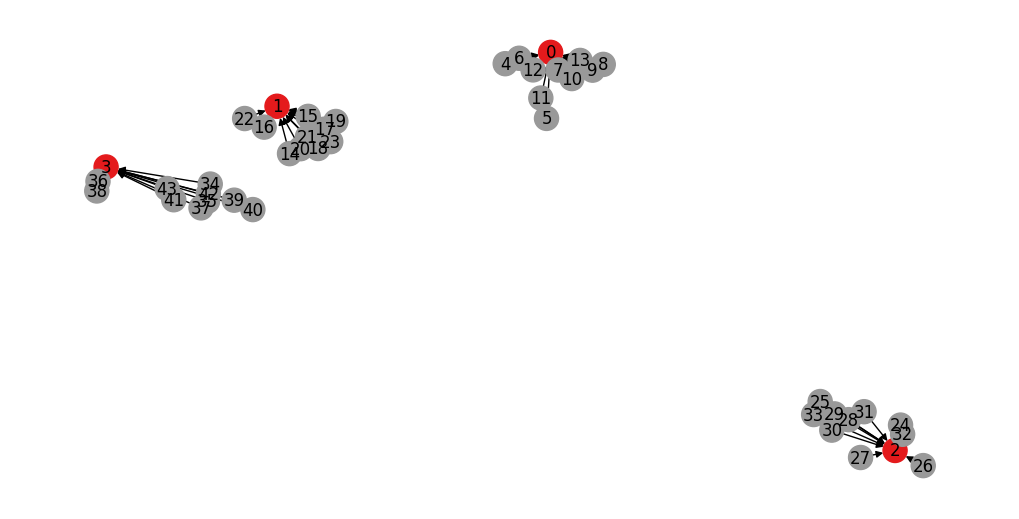

In [43]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

samples = [i.to_homogeneous() for i in iter(sampler)]
print(">>> n_samples:", len(samples))

sample = samples[100]
print(sample.is_directed())

for i in sample.keys: print(f">>> {i} ({sample[i].shape}):\n {sample[i]}")

vis = to_networkx(sample, node_attrs=["n_id"], edge_attrs=["e_id"])
plt.figure(figsize=(10, 5)) 
nx.draw(vis, node_color=sample["node_type"], cmap=plt.cm.Set1, with_labels=True)
plt.show()


In [82]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Batch

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(5, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)
        return x

model = GCN(hidden_channels=10).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

samples = [i.cuda() for i in iter(sampler)]
batches = [i.to_homogeneous() for i in iter(sampler)]

for idx, batch in enumerate(batches):
    optimizer.zero_grad()

    print(type(batch))
    print(dir(batch))

    print(batch[0])

    stop

    print(sample.x.shape)
    # x = sample.x[:5].unsqueeze(0)
    # y = sample.y[0]
    # edge_index = sample.edge_index

    # out = model(x, torch.empty(2, 0, dtype=torch.long).cuda())
    # loss = criterion(out.squeeze(), y.squeeze(0))

    # print(loss.item(), out.item(), y.item())



<class 'torch_geometric.data.data.Data'>
['__call__', '__cat_dim__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__inc__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_edge_attr_cls', '_edge_to_layout', '_edges_to_layout', '_get_edge_index', '_get_tensor', '_get_tensor_size', '_multi_get_tensor', '_put_edge_index', '_put_tensor', '_remove_edge_index', '_remove_tensor', '_store', '_tensor_attr_cls', '_to_type', 'apply', 'apply_', 'batch', 'clone', 'coalesce', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'coo', 'cpu', 'csc', 'csr', 'cuda', 'debug', 'detach', '

KeyError: 0